In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from cl_utils import train_model, unravel_index

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"
exp = "sparseCNN2"
config_init = parse_config(config_file)
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["data_dir"] = data_dir
config["batch_size"] = 32
config["num_classes"] = 11
config["freeze_params"] = "output"

# config["boost_strength"] = 0.0
# config["boost_strength_factor"] = 0.0

experiment = ContinuousSpeechExperiment(config=config)

model on GPU
Creating optimizer with learning rate= 0.01


In [3]:
model = experiment.model
f = experiment.combine_classes([2,4])

In [4]:
loader = experiment.train_loader

In [5]:
xs, ys = [], []
for x, y in loader:
    xs.append(x.cuda())
    ys.append(y.cuda())

In [6]:
f.close()

In [113]:
criterion = F.nll_loss
opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt.zero_grad()

loss = criterion(model(xs[0]), ys[0])
loss.backward()

In [114]:
weights = list(model.parameters())
weights[2].shape

torch.Size([64, 64, 5, 5])

In [136]:
weights[3].grad

tensor([-9.3132e-10, -9.3132e-10,  1.1642e-09,  1.3970e-09,  4.6566e-10,
        -2.5611e-09,  1.7462e-09, -1.8626e-09, -2.3283e-10,  4.6566e-09,
         2.3283e-10, -1.8626e-09,  2.7940e-09,  0.0000e+00,  9.3132e-10,
        -4.6566e-10,  4.6566e-10,  6.9849e-10,  9.3132e-10,  0.0000e+00,
        -9.3132e-10, -1.1642e-09, -2.3283e-10,  2.3283e-10,  9.3132e-10,
        -3.4925e-10,  2.3283e-10,  4.6566e-10,  9.3132e-10, -4.6566e-10,
         1.3970e-09, -9.3132e-10,  0.0000e+00, -9.3132e-10, -4.4238e-09,
         4.6566e-10,  8.1491e-10,  0.0000e+00, -1.6298e-09, -2.0955e-09,
         6.9849e-10,  4.6566e-10, -9.3132e-10, -1.8626e-09,  9.3132e-10,
        -2.0955e-09,  2.3283e-10,  2.3283e-09,  6.9849e-10,  4.6566e-10,
         9.3132e-10,  3.2596e-09,  1.1059e-09, -9.3132e-10,  4.6566e-10,
         1.8626e-09, -9.3132e-10,  6.9849e-10,  0.0000e+00, -4.1910e-09,
        -2.3283e-09, -1.8626e-09, -1.3970e-09,  2.0955e-09], device='cuda:0')

In [134]:
def k_grad(module, pct):
    if w.ndim > 1:
        s, inds = torch.sort(torch.abs(module.grad), axis=1)
        k = int(pct/100 * module.shape[1])

        m = module.grad.gather(1, inds)
        m[:,:-k,:,:] = 0.
    
    else:
        s, inds = torch.sort(torch.abs(module.grad))
        k = int(pct/100 * module.shape[0])
        m[:-k] = 0.
        
    module.grad = m

In [135]:
for w in weights:
    try:
        k_grad(w, 2)
    except:
        pass

In [148]:
# torch.topk?
torch.scatter?

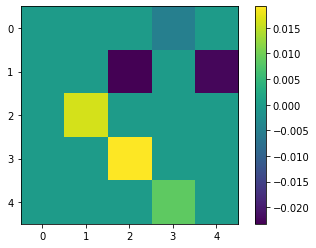

In [50]:
plt.imshow(weights[2][idx][0].detach().cpu().numpy()[0,0,:,:])
plt.colorbar()

In [45]:
for k in idx:
    weights[2].grad[k] = 0.

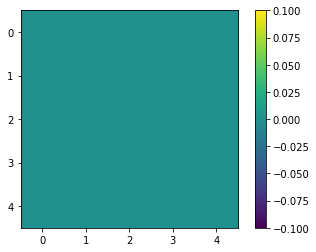

In [48]:
plt.imshow(weights[2].grad[idx][0].detach().cpu().numpy()[0,0,:,:])
plt.colorbar()

In [47]:
opt.step()

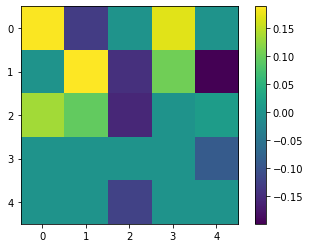

In [77]:
plt.imshow(weights[0][idx][0].detach().cpu().numpy()[0,0,:,:])
plt.colorbar()

In [12]:
train_model(model, loader, experiment.optimizer, experiment.device,
            batches_in_epoch=experiment.batches_in_epoch)

In [14]:
weights = list(model.parameters())
n_weights = [k.detach().cpu().numpy() for k in weights]
g_weights = [k.grad.detach().cpu().numpy() for k in weights]

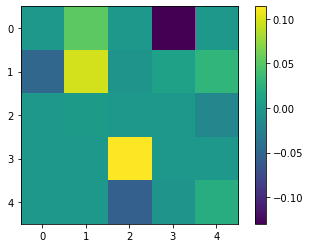

In [16]:
plt.imshow(n_weights[0][34,0,:,:])
plt.colorbar()

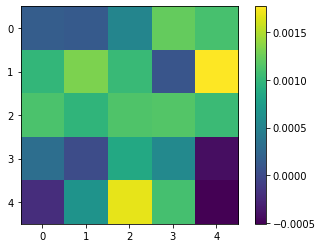

In [17]:
plt.imshow(g_weights[0][3,0,:,:])
plt.colorbar()

In [13]:
def unravel_index(index, shape):
    res = []
    for size in shape[::-1]:
        res.append(int(index % size))
        index = int(index // size)
    return tuple(res[::-1])

In [14]:
s, inds = torch.sort(weights[0].flatten())

k= 32 # top k
idx = [unravel_index(ind, weights[0].shape) for ind in inds[:-k]]

In [ ]:
[weights[0][i] for i in idx]

In [15]:
for i in idx:
    weights[0][i] = torch.tensor(0., device=experiment.device, requires_grad=False)

In [22]:
weights[0] = torch.nn.parameter.Parameter(weights[0]).retain_grad()

In [20]:
weights[0][idx[0]]

tensor(0., device='cuda:0', grad_fn=<SelectBackward>)

In [10]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 0.0000, -0.1725, -0.0296,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1290],
           [-0.0472,  0.0000,  0.0212,  0.1573, -0.1935],
           [-0.1372, -0.0299,  0.0000, -0.0800,  0.0376],
           [ 0.0000,  0.0000, -0.1030,  0.0000, -0.1808]]],
 
 
         [[[ 0.0000,  0.0000,  0.0000,  0.1727,  0.0507],
           [ 0.0000,  0.0000,  0.1284,  0.1994, -0.1101],
           [ 0.0000,  0.0000,  0.0646, -0.1802,  0.1394],
           [ 0.0000, -0.1607,  0.0000,  0.1423,  0.0000],
           [-0.0764,  0.0000, -0.0272,  0.0000,  0.1018]]],
 
 
         [[[ 0.0138,  0.0000,  0.0100,  0.0000,  0.0000],
           [ 0.0369,  0.0000,  0.0000,  0.0975,  0.0000],
           [ 0.0051,  0.0000, -0.0517,  0.1249, -0.0760],
           [ 0.0000,  0.0518,  0.0844, -0.1592,  0.0000],
           [ 0.1600,  0.0000,  0.0000,  0.0000, -0.0717]]],
 
 
         ...,
 
 
         [[[-0.0933,  0.0000,  0.0000,  0.1173, -0.0870],
           [ 

In [144]:
weights[2].shape

torch.Size([64, 64, 5, 5])